# Build machine learning model
1. Train-test split
2. Vectorization
3. Build model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [271]:
df = pd.read_csv('../packages/reddit_svc_classifier/reddit_svc_classifier/datasets/tokenized_text.csv')

Only use a subset of the labels

In [268]:
VALID_LABELS = ['live convo', 'bad test', 'mobile', 'other', 'screeners',
       'recorder', 'ratings', 'bug', 'payment', 'no test','other company']

In [103]:
INPUT = 'tokenized'
TARGET = 'label'

In [269]:
df = df[df[TARGET].isin(VALID_LABELS)]

In [270]:
df.to_csv('../packages/reddit_svc_classifier/reddit_svc_classifier/datasets/tokenized_text.csv', index=False)

### Stratified train-test split

In [272]:
train_df, test_df = train_test_split(df, random_state=42, test_size=0.2, stratify=df[TARGET])

### Downsample the `other` class in the training data

In [273]:
train_df[TARGET].value_counts()

other            184
screeners         62
bad test          58
recorder          57
ratings           56
live convo        46
mobile            42
no test           42
bug               32
other company     28
payment           26
Name: label, dtype: int64

In [274]:
from sklearn.utils import resample

In [275]:
def downsample_majority_class(df, class_name=None, downsample_fraction=0.5):
    if class_name is not None:
        df_majority = df[df[TARGET] == class_name]
        df_others = df[df[TARGET] != class_name]
        
        n_samples = int(len(df_majority) * downsample_fraction)
    
        majority_downsampled = resample(df_majority, replace=False, 
                                        n_samples=n_samples, random_state=42)
        downsampled = pd.concat([majority_downsampled, df_others])
        return downsampled

In [276]:
MAJORITY_CLASS = 'other'
RESAMPLE_FRACTION = 0.4

In [277]:
train_downsampled = downsample_majority_class(train_df, class_name=MAJORITY_CLASS, downsample_fraction=RESAMPLE_FRACTION)

In [278]:
len(train_downsampled)

522

### Vectorization
Use the `TfidfVectorizer` from scikit-learn

In [279]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [280]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', max_features=1500)
vectorizer.fit(train_downsampled[INPUT])

TfidfVectorizer(max_features=1500, ngram_range=(1, 2))

Fit on training data

In [281]:
X_train = vectorizer.transform(train_downsampled[INPUT])
y_train = train_downsampled[TARGET]

Transform validation data using Training tokens

In [282]:
X_test = vectorizer.transform(test_df[INPUT])
y_test = test_df[TARGET]

### Build Model
- Create metrics
- Try multiple models (with cross-validation)

In [283]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [284]:
def eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

Random Forest Classifier:

In [120]:
from sklearn.ensemble import RandomForestClassifier

0.5601424968130232


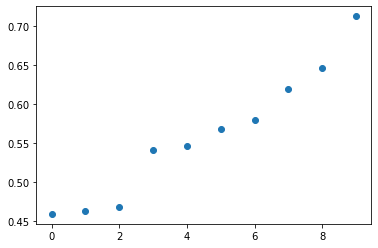

In [241]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1_weighted')
plt.plot(sorted(scores), 'o')
print(np.mean(scores))

Linear SVC

In [217]:
import numpy as np

In [222]:
import matplotlib.pyplot as plt

0.640969657056377


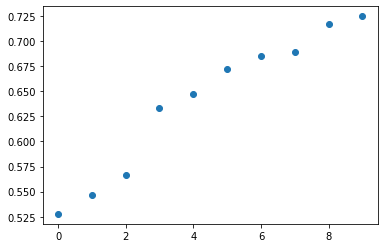

In [285]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
clf = LinearSVC(class_weight='balanced', random_state=42, C=0.01)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
plt.plot(sorted(scores), 'o')
print(np.mean(scores))

Check performance on test set

In [286]:
clf.fit(X_train, y_train)
eval_metrics(y_test, clf.predict(X_test))

{'accuracy': 0.6477987421383647,
 'f1_score': 0.6175864230088205,
 'precision': 0.7180771022594921,
 'recall': 0.6477987421383647}